# T2: 高斯混合模型与EM算法

本实验实现高斯混合模型（Gaussian Mixture Model, GMM）和期望最大化（Expectation-Maximization, EM）算法。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


## 1. 实现EM算法用于高斯混合模型


In [4]:
class GaussianMixtureModel:
    """
    高斯混合模型（GMM）使用EM算法进行训练
    
    参数:
        n_components: 混合成分的数量（高斯分布的数量）
        max_iter: 最大迭代次数
        tol: 收敛阈值
        random_state: 随机种子
    """
    
    def __init__(self, n_components=3, max_iter=100, tol=1e-6, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.weights_ = None  # 混合权重
        self.means_ = None    # 每个高斯分布的均值
        self.covariances_ = None  # 每个高斯分布的协方差矩阵
        self.log_likelihood_history_ = []
        
    def _initialize_parameters(self, X):
        """初始化模型参数"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # 初始化权重（均匀分布）
        self.weights_ = np.ones(self.n_components) / self.n_components
        
        # 随机初始化均值
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        
        # 初始化协方差矩阵（使用数据的协方差）
        cov = np.cov(X.T)
        self.covariances_ = np.array([cov for _ in range(self.n_components)])
        
    def _e_step(self, X):
        """
        E步：计算每个样本属于每个高斯分布的后验概率（责任）
        
        返回:
            responsibilities: (n_samples, n_components) 形状的数组
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # 计算每个高斯分布的概率密度
            try:
                responsibilities[:, k] = self.weights_[k] * multivariate_normal.pdf(
                    X, self.means_[k], self.covariances_[k]
                )
            except:
                # 如果协方差矩阵奇异，使用伪逆
                responsibilities[:, k] = self.weights_[k] * multivariate_normal.pdf(
                    X, self.means_[k], self.covariances_[k] + np.eye(self.covariances_[k].shape[0]) * 1e-6
                )
        
        # 归一化（使得每个样本的责任之和为1）
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities_sum[responsibilities_sum == 0] = 1e-10  # 避免除零
        responsibilities = responsibilities / responsibilities_sum
        
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """
        M步：根据当前的责任更新模型参数
        """
        n_samples, n_features = X.shape
        
        # 计算每个成分的有效样本数
        Nk = responsibilities.sum(axis=0)
        
        # 更新权重
        self.weights_ = Nk / n_samples
        
        # 更新均值
        self.means_ = np.zeros((self.n_components, n_features))
        for k in range(self.n_components):
            self.means_[k] = (responsibilities[:, k][:, np.newaxis] * X).sum(axis=0) / Nk[k]
        
        # 更新协方差矩阵
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(
                responsibilities[:, k] * diff.T, diff
            ) / Nk[k]
            
            # 添加正则化项避免奇异矩阵
            self.covariances_[k] += np.eye(n_features) * 1e-6
    
    def _compute_log_likelihood(self, X):
        """计算对数似然"""
        n_samples = X.shape[0]
        log_likelihood = 0
        
        for k in range(self.n_components):
            try:
                log_likelihood += self.weights_[k] * multivariate_normal.pdf(
                    X, self.means_[k], self.covariances_[k]
                )
            except:
                log_likelihood += self.weights_[k] * multivariate_normal.pdf(
                    X, self.means_[k], self.covariances_[k] + np.eye(self.covariances_[k].shape[0]) * 1e-6
                )
        
        log_likelihood = np.log(log_likelihood + 1e-10).sum()
        return log_likelihood
    
    def fit(self, X):
        """
        使用EM算法训练模型
        
        参数:
            X: 训练数据，形状为 (n_samples, n_features)
        """
        X = np.array(X)
        self._initialize_parameters(X)
        
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E步
            responsibilities = self._e_step(X)
            
            # M步
            self._m_step(X, responsibilities)
            
            # 计算对数似然
            log_likelihood = self._compute_log_likelihood(X)
            self.log_likelihood_history_.append(log_likelihood)
            
            # 检查收敛
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"在第 {iteration + 1} 次迭代后收敛")
                break
            
            prev_log_likelihood = log_likelihood
        
        return self
    
    def predict(self, X):
        """
        预测每个样本最可能属于哪个高斯分布
        
        参数:
            X: 测试数据
            
        返回:
            预测的类别标签
        """
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)
    
    def predict_proba(self, X):
        """
        返回每个样本属于每个高斯分布的概率
        
        参数:
            X: 测试数据
            
        返回:
            概率矩阵，形状为 (n_samples, n_components)
        """
        return self._e_step(X)


## 2. 生成测试数据


数据形状: (600, 2)
真实成分数量: 3
每个成分的样本数: 200


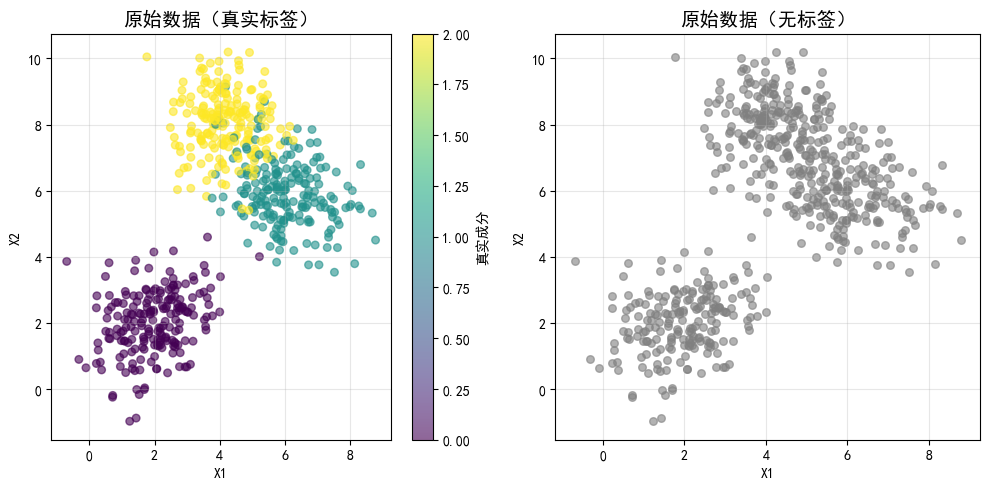

In [5]:
# 生成三个高斯分布的混合数据
np.random.seed(42)

# 定义三个高斯分布的参数
n_samples_per_component = 200
n_components = 3

# 第一个高斯分布
mean1 = [2, 2]
cov1 = [[1, 0.3], [0.3, 1]]
X1 = np.random.multivariate_normal(mean1, cov1, n_samples_per_component)

# 第二个高斯分布
mean2 = [6, 6]
cov2 = [[1, -0.3], [-0.3, 1]]
X2 = np.random.multivariate_normal(mean2, cov2, n_samples_per_component)

# 第三个高斯分布
mean3 = [4, 8]
cov3 = [[0.8, 0], [0, 0.8]]
X3 = np.random.multivariate_normal(mean3, cov3, n_samples_per_component)

# 合并数据
X = np.vstack([X1, X2, X3])
true_labels = np.hstack([
    np.zeros(n_samples_per_component),
    np.ones(n_samples_per_component),
    np.ones(n_samples_per_component) * 2
])

# 打乱数据
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
true_labels = true_labels[shuffle_idx]

print(f"数据形状: {X.shape}")
print(f"真实成分数量: {n_components}")
print(f"每个成分的样本数: {n_samples_per_component}")

# 可视化原始数据
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.6, s=30)
plt.title('原始数据（真实标签）', fontsize=14)
plt.xlabel('X1')
plt.ylabel('X2')
plt.colorbar(label='真实成分')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.6, s=30)
plt.title('原始数据（无标签）', fontsize=14)
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
# 创建并训练GMM模型
gmm = GaussianMixtureModel(n_components=3, max_iter=100, tol=1e-6, random_state=42)
gmm.fit(X)

print("训练完成！")
print(f"\n学习到的参数:")
print(f"混合权重: {gmm.weights_}")
print(f"\n均值:")
for i, mean in enumerate(gmm.means_):
    print(f"  成分 {i}: {mean}")
print(f"\n协方差矩阵:")
for i, cov in enumerate(gmm.covariances_):
    print(f"  成分 {i}:")
    print(f"    {cov}")


训练完成！

学习到的参数:
混合权重: [0.30550761 0.36355525 0.33093714]

均值:
  成分 0: [4.14921376 8.19712045]
  成分 1: [5.91278011 5.97285756]
  成分 2: [1.9522406  2.00239555]

协方差矩阵:
  成分 0:
    [[ 0.62674337 -0.03586796]
 [-0.03586796  0.75217523]]
  成分 1:
    [[ 1.20828202 -0.30783855]
 [-0.30783855  0.94087822]]
  成分 2:
    [[0.84119349 0.22985615]
 [0.22985615 0.91581628]]


## 4. 可视化EM算法的收敛过程


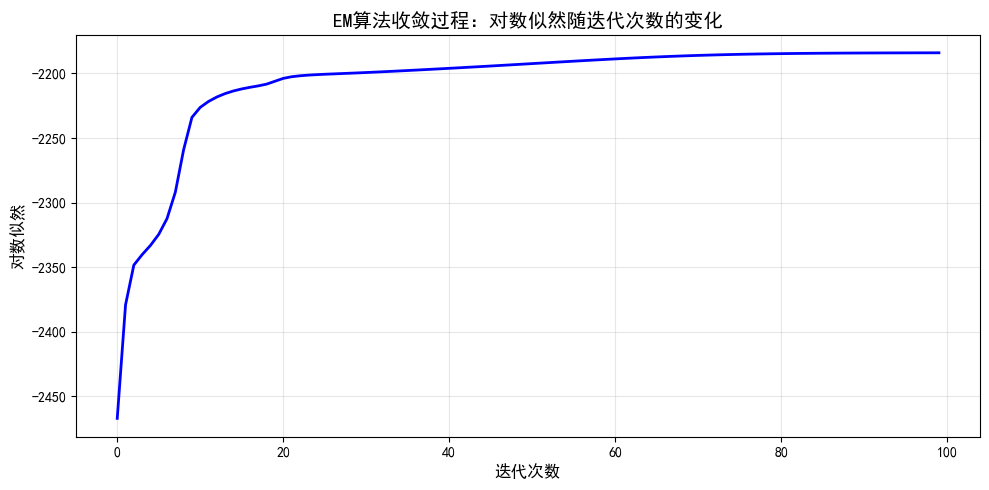

初始对数似然: -2466.9761
最终对数似然: -2184.1402
对数似然提升: 282.8359


In [7]:
# 绘制对数似然随迭代次数的变化
plt.figure(figsize=(10, 5))
plt.plot(gmm.log_likelihood_history_, 'b-', linewidth=2)
plt.xlabel('迭代次数', fontsize=12)
plt.ylabel('对数似然', fontsize=12)
plt.title('EM算法收敛过程：对数似然随迭代次数的变化', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"初始对数似然: {gmm.log_likelihood_history_[0]:.4f}")
print(f"最终对数似然: {gmm.log_likelihood_history_[-1]:.4f}")
print(f"对数似然提升: {gmm.log_likelihood_history_[-1] - gmm.log_likelihood_history_[0]:.4f}")


## 5. 预测和可视化结果


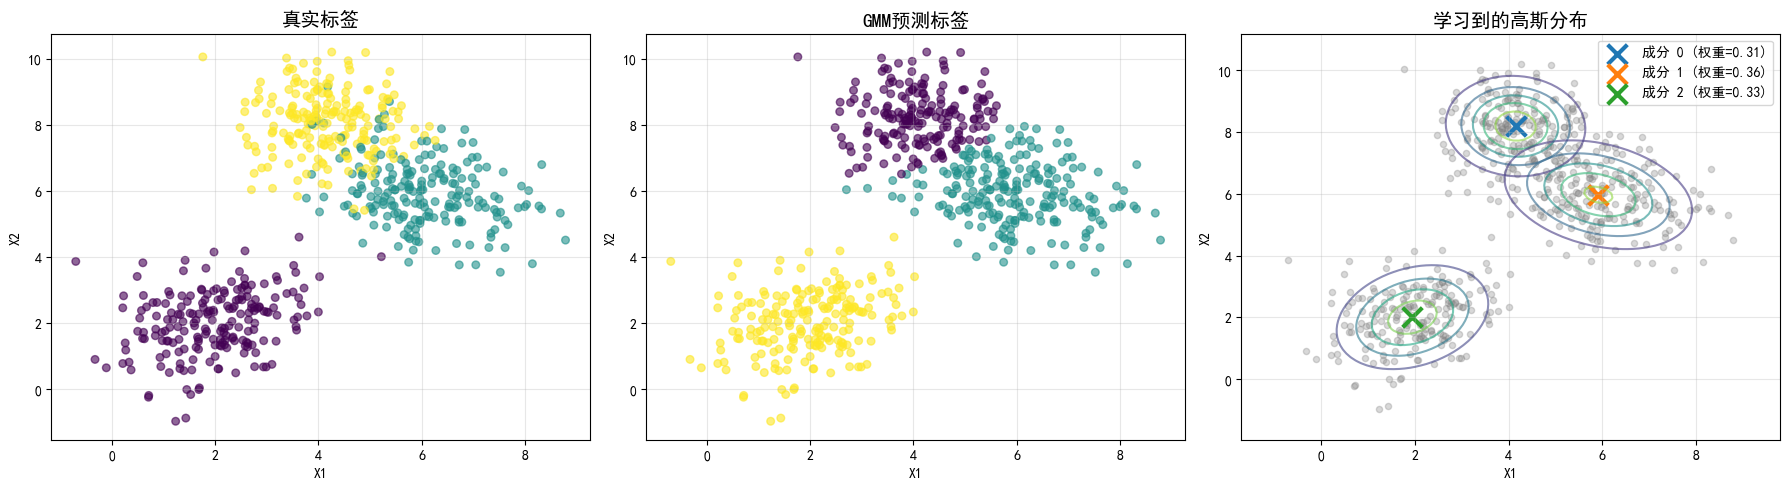

In [8]:
# 预测每个样本的类别
predicted_labels = gmm.predict(X)
probabilities = gmm.predict_proba(X)

# 可视化预测结果
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 真实标签
axes[0].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.6, s=30)
axes[0].set_title('真实标签', fontsize=14)
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')
axes[0].grid(True, alpha=0.3)

# 预测标签
axes[1].scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', alpha=0.6, s=30)
axes[1].set_title('GMM预测标签', fontsize=14)
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')
axes[1].grid(True, alpha=0.3)

# 绘制学习到的高斯分布
axes[2].scatter(X[:, 0], X[:, 1], c='gray', alpha=0.3, s=20)
for k in range(gmm.n_components):
    # 绘制等高线
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    try:
        zz = multivariate_normal.pdf(grid_points, gmm.means_[k], gmm.covariances_[k])
    except:
        zz = multivariate_normal.pdf(grid_points, gmm.means_[k], 
                                     gmm.covariances_[k] + np.eye(2) * 1e-6)
    zz = zz.reshape(xx.shape)
    axes[2].contour(xx, yy, zz, levels=5, alpha=0.6)
    axes[2].scatter(gmm.means_[k, 0], gmm.means_[k, 1], 
                   marker='x', s=200, linewidths=3, 
                   label=f'成分 {k} (权重={gmm.weights_[k]:.2f})')

axes[2].set_title('学习到的高斯分布', fontsize=14)
axes[2].set_xlabel('X1')
axes[2].set_ylabel('X2')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. 评估模型性能


In [9]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 计算评估指标
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)

print("模型性能评估:")
print(f"调整兰德指数 (ARI): {ari:.4f}")
print(f"标准化互信息 (NMI): {nmi:.4f}")
print(f"\n最终对数似然: {gmm.log_likelihood_history_[-1]:.4f}")

# 显示每个成分的统计信息
print("\n各成分的统计信息:")
for k in range(gmm.n_components):
    component_mask = predicted_labels == k
    n_samples_in_component = np.sum(component_mask)
    print(f"\n成分 {k}:")
    print(f"  样本数: {n_samples_in_component}")
    print(f"  权重: {gmm.weights_[k]:.4f}")
    print(f"  均值: {gmm.means_[k]}")
    print(f"  协方差矩阵的行列式: {np.linalg.det(gmm.covariances_[k]):.6f}")


模型性能评估:
调整兰德指数 (ARI): 0.7985
标准化互信息 (NMI): 0.7831

最终对数似然: -2184.1402

各成分的统计信息:

成分 0:
  样本数: 186
  权重: 0.3055
  均值: [4.14921376 8.19712045]
  协方差矩阵的行列式: 0.470134

成分 1:
  样本数: 215
  权重: 0.3636
  均值: [5.91278011 5.97285756]
  协方差矩阵的行列式: 1.042082

成分 2:
  样本数: 199
  权重: 0.3309
  均值: [1.9522406  2.00239555]
  协方差矩阵的行列式: 0.717545


## 7. 比较不同成分数量的效果


在第 21 次迭代后收敛


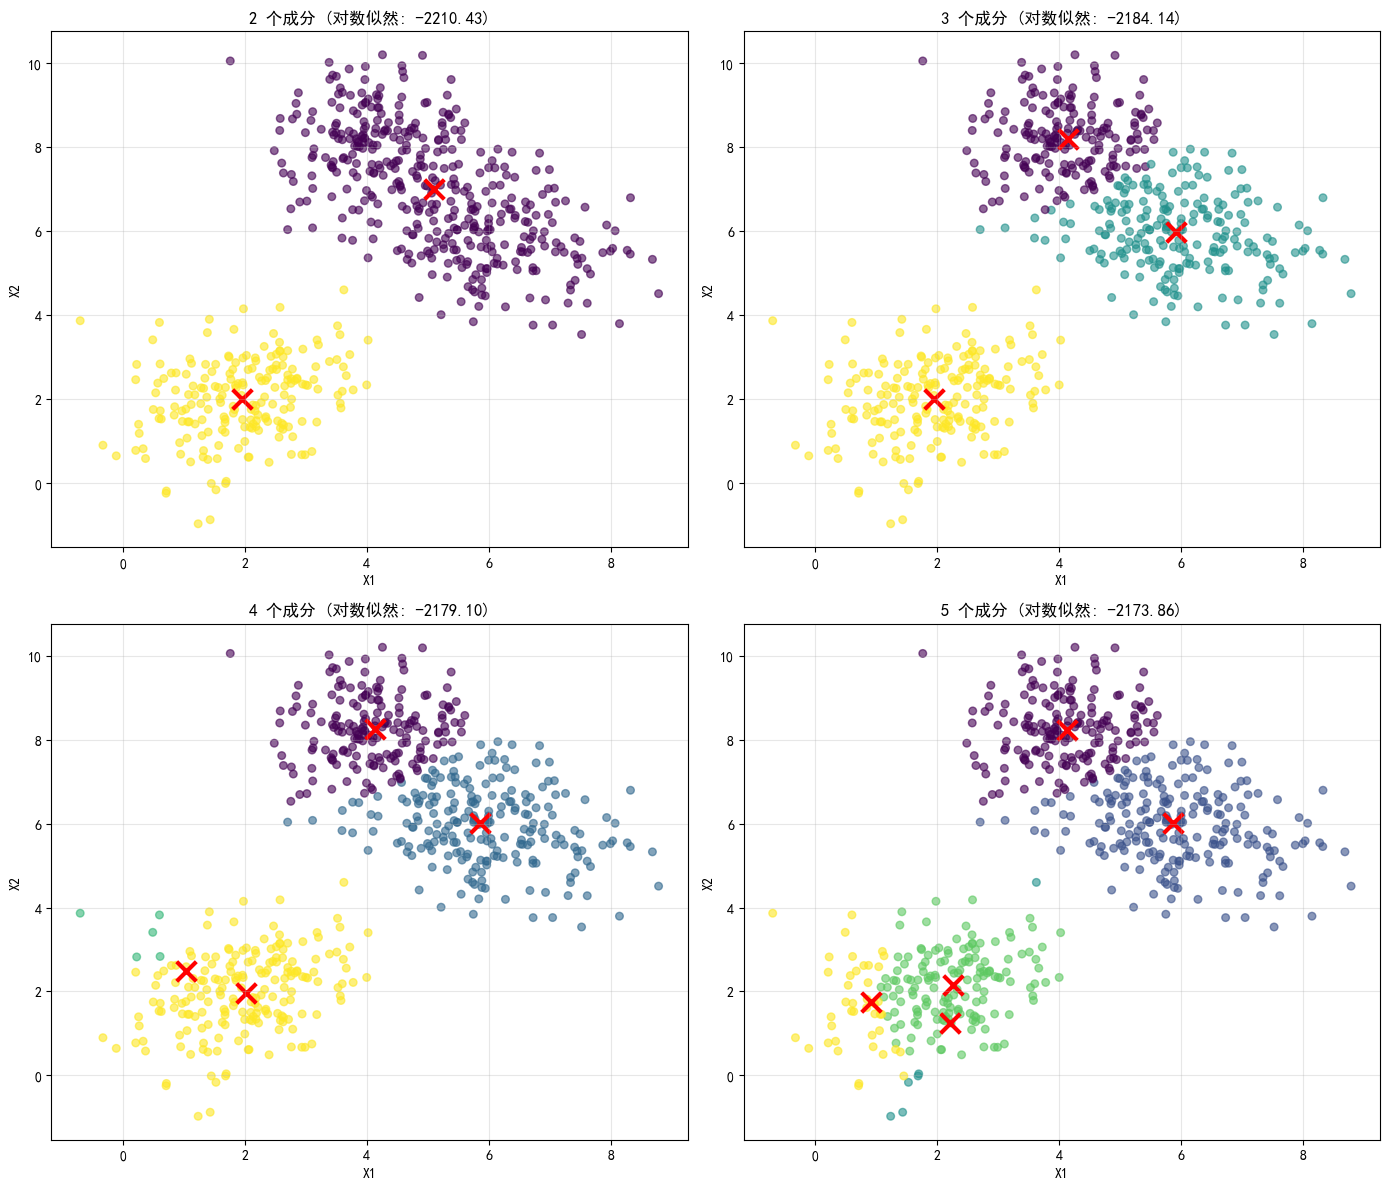

不同成分数量的对数似然:
在第 21 次迭代后收敛
  2 个成分: -2210.4259
  3 个成分: -2184.1402
  4 个成分: -2179.0959
  5 个成分: -2173.8606


In [10]:
# 测试不同成分数量的效果
n_components_list = [2, 3, 4, 5]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, n_comp in enumerate(n_components_list):
    gmm_test = GaussianMixtureModel(n_components=n_comp, max_iter=100, 
                                    tol=1e-6, random_state=42)
    gmm_test.fit(X)
    pred_labels = gmm_test.predict(X)
    
    # 绘制结果
    scatter = axes[idx].scatter(X[:, 0], X[:, 1], c=pred_labels, 
                               cmap='viridis', alpha=0.6, s=30)
    
    # 绘制均值
    for k in range(n_comp):
        axes[idx].scatter(gmm_test.means_[k, 0], gmm_test.means_[k, 1],
                         marker='x', s=200, linewidths=3, color='red')
    
    axes[idx].set_title(f'{n_comp} 个成分 (对数似然: {gmm_test.log_likelihood_history_[-1]:.2f})', 
                        fontsize=12)
    axes[idx].set_xlabel('X1')
    axes[idx].set_ylabel('X2')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印不同成分数量的对数似然
print("不同成分数量的对数似然:")
for n_comp in n_components_list:
    gmm_test = GaussianMixtureModel(n_components=n_comp, max_iter=100, 
                                    tol=1e-6, random_state=42)
    gmm_test.fit(X)
    print(f"  {n_comp} 个成分: {gmm_test.log_likelihood_history_[-1]:.4f}")
